<a href="https://colab.research.google.com/github/changhorang/SSAC_study/blob/main/DL3%20(PyTorch)/note/test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# requirements
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 448 kB 37.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-12-27 07:19:13--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c5:2ef4, 2406:da00:ff00::22e9:9f55, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.

In [3]:
%cd ../

/content


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from konlpy.tag import Mecab

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

from nltk import FreqDist
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset


import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
np.random.seed(0)
torch.manual_seed(0)

# 현재 컴퓨터에서 CUDA(GPU Library)를 이용할 수 있는지 알아보기 위한 Flag
USE_CUDA = torch.cuda.is_available()
# USE_CUDA가 True일 경우, GPU를 할당 그 외엔 CPU 메모리 할당
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 30
lr = 1e-3

n_layers = 1
vocab_size = 13294
embed_dim = 128
hidden_dim = 256
n_classes = 3
dropout_p = 0.5
batch_size = 100
nhead = 2

print(DEVICE)

cuda


# Preprocessing

In [3]:
# preprocessing

def preprocessing():
    
    train_df = pd.read_csv(f'/content/drive/MyDrive/korean-hate-speech-detection/train.hate.csv')
    dev_df = pd.read_csv(f'/content/drive/MyDrive/korean-hate-speech-detection/dev.hate.csv')
    test_df = pd.read_csv(f'/content/drive/MyDrive/korean-hate-speech-detection/test.hate.csv')

    le = LabelEncoder()
        
    train_df['label'] = le.fit_transform(train_df['label'])
    dev_df['label'] = le.fit_transform(dev_df['label'])

    # print(le.inverse_transform([0, 1, 2]))
    # ['hate' 'none' 'offensive'] = [0, 1, 2]

    train_df['comments'] = train_df['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    dev_df['comments'] = dev_df['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_df['comments'] = dev_df['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

    train_df.to_csv('train.txt', sep='\t', index=False)
    dev_df.to_csv('dev.txt', sep='\t', index=False)
    test_df.to_csv('test.txt', sep='\t', index=False)
    
    # train_df = train_df.to_dict('list')
    # dev_df = dev_df.to_dict('list')
    # test_df = test_df.to_dict('list')
    
    print(train_df)

    # with open('train.txt', 'w', encoding='utf-8') as f:
    #     for comments, label in train_df.items():
    #         f.write(f'{comments} : {label}\n')
    
    # with open('dev.txt', 'w', encoding='utf-8') as f:
    #     for comments, label in dev_df.items():
    #         f.write(f'{comments} : {label}\n')

    # with open('test.txt', 'w', encoding='utf-8') as f:
    #     for comments in test_df.items():
    #         f.write(f'{comments}\n')

if __name__ == '__main__':

    preprocessing()

                                               comments  label
0       현재 호텔주인 심정 아 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네      0
1       한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ      1
2     못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...      0
3                          화 어설펐는데 화 지나서부터는 갈수록 너무 재밌던데      1
4          사람 얼굴 손톱으로 긁은것은 인격살해이고 동영상이 몰카냐 메걸리안들 생각이 없노      0
...                                                 ...    ...
7891                                         힘내세요 응원합니다      1
7892                                 힘내세요삼가 고인의 명복을 빕니다      1
7893                                   힘내세용  항상 응원합니닷        1
7894        힘내소연기로 답해요나도 살 인데 이런일 저런일 다 있더라구요인격을 믿습니다홨팅      1
7895                                 힘들면 관뒀어야지 그게 현명한거다      1

[7896 rows x 2 columns]


# Build_vocab

In [ ]:
# # build_vocab
# # nltk.download('punkt') # nltk 사용을 위해 설치

# import nltk
# import pickle
# import argparse
# from collections import Counter

# class Vocabulary(object):
#     """simple vocabulary wrapper."""
#     def __init__(self):
#         self.word2idx = {}
#         self.idx2word = {}
#         self.idx = 0

#     def add_word(self, word):
#         if not word in self.word2idx:
#             self.word2idx[word] = self.idx
#             self.idx2word[self.idx] = word
#             self.idx += 1

#     def __call__(self, word):
#         if not word in self.word2idx:
#             return self.word2idx['<unk>']
#         return self.word2idx[word]

#     def __len__(self):
#         return len(self.word2idx)


# def build_vocab(json, threshold):
#     """build a simple vocabulary wrapper."""
#     counter = Counter() # list안의 단어의 출현 빈도 dict로 반환
    
#     ids = pd.read_csv('train.csv')['comments']

#     # 불용어 정의
#     stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

#     # 형태소 분석기
#     tokenizer = Mecab()
#     # tokenized = []

#     for sentence in ids:
#         temp = tokenizer.morphs(sentence) # 토큰화
#         temp = [word for word in temp if not word in stopwords] # 불용어 제거
#         # tokenized.append(temp)
#         counter.update(temp)

#     # if the wod frequency is less than 'threshold', then the word is discarded.
#     words = [word for word, cnt in counter.items() if cnt >= threshold]
   
#     # max_len = max(len(l) for l in encoded)
    
#     # print('리뷰의 최대 길이 : %d' % max(len(l) for l in encoded))
    
#     # create a vocab wrapper and add some special tokens.
#     vocab = Vocabulary()
#     vocab.add_word('<pad>')
#     # vocab.add_word('<sos>')
#     # vocab.add_word('<eos>')
#     vocab.add_word('<unk>')

#     # add the words to the vocabulary.
#     for i, word in enumerate(words):
#         vocab.add_word(word)

#     return vocab

# def main():
#     data_path = 'train.csv'
#     vocab_path = 'vocab.pkl'
#     threshold = 1
#     vocab = build_vocab(json=data_path, threshold=threshold)
#     # vocab_path = args.vocab_path

#     # vocab = build_vocab(json=args.data_path, threshold=args.threshold)
#     # vocab_path = args.vocab_path

#     with open(vocab_path, 'wb') as f:
#         pickle.dump(vocab, f)

#     print(f'Total vocabulary size {len(vocab)}')
    
#     print(f'Saved the vocabulary wrapper to {vocab_path}')

# if __name__ == '__main__':
#     # parser = argparse.ArgumentParser()
#     # parser.add_argument('--data_path', type=str, 
#     #                     default='train.csv', 
#     #                     help='path for train annotation file')
#     # parser.add_argument('--vocab_path', type=str, default='data/vocab.pkl', 
#     #                     help='path for saving vocabulary wrapper')
#     # parser.add_argument('--threshold', type=int, default=3, 
#     #                     help='minimum word count threshold')
#     # args = parser.parse_args()
#     main()

Total vocabulary size 13294
Saved the vocabulary wrapper to vocab.pkl


리뷰의 최대 길이 : 61
리뷰의 최소 길이 : 1
리뷰의 평균 길이 : 15.661221


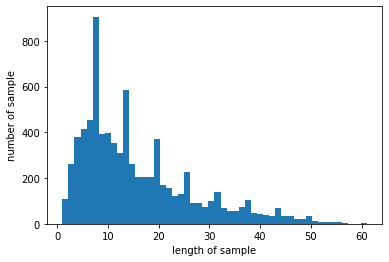

In [ ]:
# # Customdataset
# vocab_path = 'vocab.pkl'

# train_df = pd.read_csv('train.csv')['comments']
# valid_df = pd.read_csv('dev.csv')['comments']
# stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# # 형태소 분석기
# tokenizer = Mecab()
# tokenized = []
# tokenized2 = []

# for sentence in train_df:
#     temp = tokenizer.morphs(sentence) # 토큰화
#     temp = [word for word in temp if not word in stopwords] # 불용어 제거
#     tokenized.append(temp)

# for sentence in valid_df:
#     temp = tokenizer.morphs(sentence) # 토큰화
#     temp = [word for word in temp if not word in stopwords] # 불용어 제거
#     tokenized2.append(temp)

# # Load vocabulary wrapper
# with open(vocab_path, 'rb') as f:
#     vocab = pickle.load(f)

# X_train = []

# for line in tokenized: #입력 데이터에서 1줄씩 문장을 읽음
#     temp = []
#     for w in line: #각 줄에서 1개씩 글자를 읽음
#       try:
#         temp.append(vocab.word2idx[w]) # 글자를 해당되는 정수로 변환
#       except KeyError: # 단어 집합에 없는 단어일 경우 unk로 대체된다.
#         temp.append(vocab.word2idx['<unk>']) # unk의 인덱스로 변환
#     X_train.append(temp)

# X_valid = []
# for line in tokenized2: #입력 데이터에서 1줄씩 문장을 읽음
#     temp = []
#     for w in line: #각 줄에서 1개씩 글자를 읽음
#       try:
#         temp.append(vocab.word2idx[w]) # 글자를 해당되는 정수로 변환
#       except KeyError: # 단어 집합에 없는 단어일 경우 unk로 대체된다.
#         temp.append(vocab.word2idx['<unk>']) # unk의 인덱스로 변환
#     X_valid.append(temp)


# max_len = max(len(l) for l in X_train)
# print('리뷰의 최대 길이 : %d' % max_len)
# print('리뷰의 최소 길이 : %d' % min(len(l) for l in X_train))
# print('리뷰의 평균 길이 : %f' % (sum(map(len, X_train))/len(X_train)))
# plt.hist([len(s) for s in X_train], bins=50)
# plt.xlabel('length of sample')
# plt.ylabel('number of sample')
# plt.show()

In [ ]:
# for line in X_train:
#     if len(line) < max_len: # 현재 샘플이 정해준 길이보다 짧으면
#         line += [vocab.word2idx['<pad>']] * (max_len - len(line)) # 나머지는 전부 'pad' 토큰으로 채운다.

# for line in X_valid:
#     if len(line) < max_len: # 현재 샘플이 정해준 길이보다 짧으면
#         line += [vocab.word2idx['<pad>']] * (max_len - len(line)) # 나머지는 전부 'pad' 토큰으로 채운다.



# print('리뷰의 최대 길이 : %d' % max(len(l) for l in X_train))
# print('리뷰의 최소 길이 : %d' % min(len(l) for l in X_train))
# print('리뷰의 평균 길이 : %f' % (sum(map(len, X_train))/len(X_train)))


# print('리뷰의 최대 길이 : %d' % max(len(l) for l in X_valid))
# print('리뷰의 최소 길이 : %d' % min(len(l) for l in X_valid))
# print('리뷰의 평균 길이 : %f' % (sum(map(len, X_valid))/len(X_valid)))

리뷰의 최대 길이 : 61
리뷰의 최소 길이 : 61
리뷰의 평균 길이 : 61.000000
리뷰의 최대 길이 : 61
리뷰의 최소 길이 : 61
리뷰의 평균 길이 : 61.000000


In [ ]:
# X_train = pd.DataFrame(X_train)
# X_valid = pd.DataFrame(X_valid)
# y_train = pd.read_csv('train.csv')['label']
# y_valid = pd.read_csv('dev.csv')['label']

# X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((7896, 61), (471, 61), (7896,), (471,))

In [ ]:
# batch_size = 200

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # [200, 61]
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
# for X_train, y_train in train_dataloader:
#     print(X_train)

KeyError: ignored

In [4]:
tokenizer = Mecab()

# train_set = pd.read_csv('train.csv')['comments']
# valid_set = pd.read_csv('dev.csv')['comments']

TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=tokenizer.morphs, # 토크나이저로는 Mecab 사용.
                  lower=True,
                  batch_first=True,
                  fix_length=61)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   preprocessing=lambda x : int(x),
                   is_target=True)

In [5]:
train_data, valid_data = TabularDataset.splits(path='.', train='train.txt', validation='dev.txt', format='tsv',
                                               fields=[('comments', TEXT), ('label', LABEL)], skip_header=True)

In [6]:
print(vars(train_data[0]))

{'comments': ['현재', '호텔', '주인', '심정', '아', '난', '마른', '하늘', '에', '날벼락', '맞', '고', '호텔', '망하', '게', '생겼', '는데', '누군', '계속', '추모', '받', '네'], 'label': 0}


In [7]:
TEXT.build_vocab(train_data, min_freq=1, max_size=12000)
print('단어 집합의 크기 : {}'.format(len(TEXT.vocab)))
print(TEXT.vocab.stoi)

단어 집합의 크기 : 12002
defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f5442c06490>>, {'<unk>': 0, '<pad>': 1, '이': 2, '는': 3, '하': 4, '고': 5, '들': 6, '다': 7, '가': 8, '은': 9, '도': 10, '지': 11, '에': 12, '거': 13, '네': 14, '을': 15, '게': 16, '한': 17, '나': 18, '있': 19, '안': 20, '보': 21, '면': 22, 'ㅋㅋ': 23, '없': 24, '아': 25, '잘': 26, '는데': 27, '좋': 28, '냐': 29, 'ㅋㅋㅋ': 30, '만': 31, '어': 32, '같': 33, '겠': 34, '여자': 35, '의': 36, '사람': 37, '로': 38, '아니': 39, '왜': 40, '니': 41, '를': 42, '되': 43, '했': 44, '것': 45, '으로': 46, '기': 47, '해': 48, '좀': 49, '말': 50, '에서': 51, '음': 52, '너무': 53, '진짜': 54, '주': 55, '라': 56, '인': 57, '듯': 58, '었': 59, '야': 60, '남자': 61, '할': 62, '뭐': 63, '못': 64, '살': 65, '애': 66, '더': 67, '많': 68, '세요': 69, '않': 70, '때': 71, '서': 72, '네요': 73, '으면': 74, '시': 75, '적': 76, '씨': 77, '일': 78, '그': 79, '알': 80, '건': 81, '았': 82, '연기': 83, '나오': 84, '수': 85, '인데': 86, '지만': 87, '결혼': 88, '그냥': 89, '라고': 90, '자': 91, '내': 92, '까지': 93, '돈

In [8]:
from torchtext.legacy.data import Iterator

train_iter, val_iter = data.BucketIterator.splits(
                                (train_data, valid_data), batch_size=batch_size,
                                shuffle=True, repeat=False, sort=False)
 

print('훈련 데이터의 미니 배치 수 : {}'.format(len(train_iter)))
print('테스트 데이터의 미니 배치 수 : {}'.format(len(val_iter)))

훈련 데이터의 미니 배치 수 : 79
테스트 데이터의 미니 배치 수 : 5


# Model

In [45]:
class GRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
        h_t = x[:,-1,:] # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
        self.dropout(h_t)
        logit = self.out(h_t)  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)
        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [12]:
class Transformer_model(nn.Module):
    def __init__(self, batch_size, n_vocab, embed_dim, nhead, n_classes, num_layers, dropout_p=0.2):
        super(Transformer_model, self).__init__()
        
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.n_vocab = n_vocab
        self.nhead = nhead
        self.embed_dim = embed_dim

        self.embedding1 = nn.Embedding(n_vocab, embed_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.transformer = nn.Transformer(embed_dim, nhead=nhead, batch_first=True) # [batch_size, 1, embed_dim]
        self.decoder = nn.Linear(self.embed_dim, n_classes) # [batch_size, 1, embed_dim]
        self.embedding2 = nn.Linear(1, embed_dim)

    def forward(self, X, y):
        src_embed = self.embedding1(X)
        tgt_embed = self.embedding2(y)
        
        output = self.transformer(src_embed, tgt_embed)
        # [batch_size, n_future, dim_embed]

        output = self.decoder(output)
        # [batch_size, n_future, n_future]

        return output

In [13]:
#model = GRU(n_layers=n_layers, hidden_dim=hidden_dim, n_vocab=vocab_size, embed_dim=embed_dim, n_classes=n_classes, dropout_p=dropout_p).to(DEVICE)
model = Transformer_model(batch_size=batch_size, n_vocab=vocab_size, embed_dim=embed_dim, nhead=nhead, n_classes=n_classes, num_layers=n_layers, dropout_p=dropout_p).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(DEVICE)

In [14]:
for epoch in range(1, EPOCHS+1):
    model.train()
    avg_cost = 0
    total_batch = len(train_iter)
    
    
    for X_train, y_train in train_iter:
      X_train = X_train.to(DEVICE)
      y_train = y_train.to(DEVICE)
  
      optimizer.zero_grad()

      hypothesis = model(X_train, y_train)

      cost = criterion(hypothesis, y_train)
      cost.backward()
      optimizer.step()

      avg_cost += cost/total_batch
      
      correct_prediction = torch.argmax(hypothesis, 1) == y_train
    print('=====================================Train=====================================')
    print(f'Train accuracy_score = {accuracy_score(y_train.cpu().detach().numpy(), correct_prediction.cpu().detach().numpy()):0.4f}')
    print(f'Train f1_score = {f1_score(y_train.cpu().detach().numpy(), correct_prediction.cpu().detach().numpy(), average="weighted"):0.4f}')

    print('Epoch:', '%04d' % (epoch), 'cost =', '{:.9f}'.format(avg_cost))

with torch.no_grad():
    model.eval()
    for X_val, y_val in val_iter:
        X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE)
        prediction = model(X_val, y_val)
        correct_prediction = torch.argmax(prediction, 1) == y_val
        accuracy = correct_prediction.float().mean()
        
        print('=====================================Validation=====================================')
        print('Validation Accuracy:', accuracy.item())
        print(f'Validation accuracy_score = {accuracy_score(y_val.cpu().detach().numpy(), correct_prediction.cpu().detach().numpy()):0.4f}')
        print(f'Validation f1_score = {f1_score(y_val.cpu().detach().numpy(), correct_prediction.cpu().detach().numpy(), average="weighted"):0.4f}')

print('Learning finished')

RuntimeError: ignored

In [ ]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.comments.to(DEVICE), batch.label.to(DEVICE)
        # y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        
        loss.backward()
        optimizer.step()

In [ ]:
def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.comments.to(DEVICE), batch.label.to(DEVICE)
        # y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [ ]:
best_val_loss = None
for epoch in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
    # val_loss, val_accuracy = evaluate(model, val_iter)

    # print("[Epoch: %d] val loss : %5.2f | val accuracy : %5.2f" % (epoch, val_loss, val_accuracy))

    # # 검증 오차가 가장 적은 최적의 모델을 저장
    # if not best_val_loss or val_loss < best_val_loss:
    #     if not os.path.isdir("snapshot"):
    #         os.makedirs("snapshot")
    #     torch.save(model.state_dict(), './snapshot/txtclassification.pt')
    #     best_val_loss = val_loss

TypeError: ignored

# Test Dataset Prediction